In [1]:
import random
random.seed(4)
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil 
import time
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import scipy
import scipy.misc as ff
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import keras 


In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard


def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""
    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(128, 128, 1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(0.25))


    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu',kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(labels_dim, activation='softmax', kernel_initializer='glorot_uniform'))
    model.summary()
    compile_model(model)
    return model


def compile_model(model):
    opt = keras.optimizers.Adagrad(lr=0.01)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def read_train_data():
    data = np.load("trainDataSmall.npz")
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    return [X_train, Y_train]


def read_test_data():
    data = np.load("testDataSmall.npz")
    X_test = data["X_test"]
    Y_test = data["Y_test"]
    return [X_test, Y_test]

def get_latest(checkpoint_dir, filetype='.h5', signature='cp', overwrite=False):
    """ 
        This is a workaround as tf.train.latest_checkpoint does not seem to
        work well on codalab. Give preference to that function when possible.

        If overwrite is True, the latest checkpoint is reset to 0 and all 
        others are deleted.
    """
    latest = None
    latest_number = -1
    for filename in os.listdir(checkpoint_dir):
        reference, extension = os.path.splitext(filename)
        if extension == filetype and reference.startswith('cp'):
            number = int(re.sub(r"\D", "", reference))
            if number > latest_number:
                latest = filename
                latest_number = number
            else:
                if overwrite:
                    os.remove(os.path.join(checkpoint_dir, filename))
    if latest is None:
        raise ValueError('No previous checkpoint found.')
    if overwrite:
        os.rename(os.path.join(checkpoint_dir, latest), os.path.join(checkpoint_dir, 'cp-0000.h5'))
        latest = 'cp-0000.h5'
        shutil.rmtree(os.path.join(checkpoint_dir, 'logs')) 
    return os.path.join(checkpoint_dir, latest)


In [3]:
CLASS_SIZE = 5
FILE_PATH = 'cp-{epoch:04d}.h5'
RETINOPATHY_MODEL = 'retinopathy.h5'


def run(num_epochs=100,  # Maximum number of epochs on which to train
        train_batch_size=40,  # Batch size for training steps
        job_dir='jobdir', # Local dir to write checkpoints and export model
        checkpoint_epochs='epoch',  #  Save checkpoint every epoch
        load_previous_model=False):
  
    """ This function trains the model for a number of epochs and returns the 
        training history. The model is periodically saved for later use.

        You can load a pre-trained model with 
            `model.load_weights(cp_path)`
        where `model` is a keras object (e.g. as returned by `model_fn`) and 
        `cp_path` is the path for the checkpoint you want to load.
        
        Setting load_previous_model to True will load the latest checkpoint in
        `job_dir` and continue training. That checkpoint is renamed cp-0000.h5,
        while all logs and other checkpoints are deleted. Use with care!
    
    """
    
    tf.keras.backend.clear_session()

    try:
        os.makedirs(job_dir)
    except:
        pass

    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    retinopathy_model = model_fn(CLASS_SIZE)
    if load_previous_model:
        # Load the previously saved weights
        latest = get_latest(job_dir, overwrite=True)
        retinopathy_model.load_weights(latest)

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        save_freq=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        update_freq='epoch',
        write_graph=True,
        embeddings_freq=0)

    callbacks = [checkpoint, tblog]
    
    #Data pre-processing
    #Converting the images to grayscale and performing edge mapping 
    def sada(ddd):
        anas = ddd
        sopa = []
        for x in range(0,len(anas)):
            formatted = (anas[x] * 255).astype('uint8')
            img = Image.fromarray(formatted)
            open_cv_image = np.array(img) 
            g = cv2.cvtColor(open_cv_image,cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(g,20,150)
            sopa.append(edges)
        return np.array(sopa)
    
    [X_train, Y_train] = sada(read_train_data()[0]),read_train_data()[1]
    [X_test, Y_test] = sada(read_test_data()[0]),read_test_data()[1]
    
    #Shapping the training data in order for it to be readable by keras since we are working with grayscale images
    img_rows=X_train[0].shape[0]
    img_cols=X_test[0].shape[1]

    X_train=X_train.reshape(X_train.shape[0],img_rows,img_cols,1)

    X_test=X_test.reshape(X_test.shape[0],img_rows,img_cols,1)
    Input_shape=(img_rows,img_cols,1)
    
    
    # Data augmentation. Other operations are possible.
    # https://keras.io/api/preprocessing/image/#imagedatagenerator-class
    datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

    history = retinopathy_model.fit(
              datagen.flow(X_train, Y_train, batch_size=train_batch_size, seed=4),
              steps_per_epoch=100,
              epochs=num_epochs,
              callbacks=callbacks,
              verbose=2,
              validation_data=(X_test, Y_test))

    retinopathy_model.save(os.path.join(job_dir, RETINOPATHY_MODEL))

    return history



In [4]:
#from google.colab import drive
#drive.mount('/content/drive') ## If you want to read from your drive - this is not required, as you can get the files as below, but it might faster

## this will download the data from the internet, it may fail if the server is not up

![ -f testDataSmall.npz ] || wget -O testDataSmall.npz "https://www.win.tue.nl/~cdecampos/testDataSmall.npz"
![ -f trainDataSmall.npz ] || wget -O trainDataSmall.npz "https://www.win.tue.nl/~cdecampos/trainDataSmall.npz"

history = run(load_previous_model=False, num_epochs=35, train_batch_size = 40)
#drive.flush_ad_unmount() ## if you need to unmount your google drive

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0

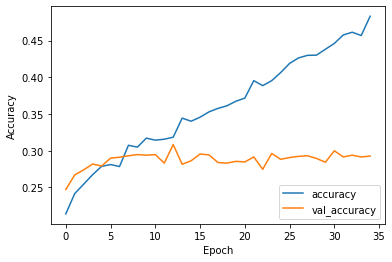

In [5]:
# Plot history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Confusion Matrix

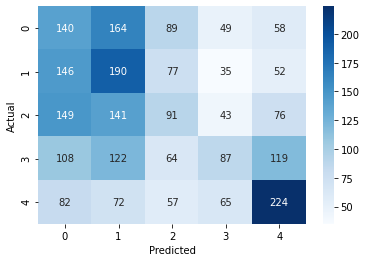

In [16]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def sada(ddd):
        anas = ddd
        sopa = []
        for x in range(0,len(anas)):
            formatted = (anas[x] * 255).astype('uint8')
            img = Image.fromarray(formatted)
            open_cv_image = np.array(img) 
            g = cv2.cvtColor(open_cv_image,cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(g,20,150)
            sopa.append(edges)
        return np.array(sopa)
    
X_test = sada(read_test_data()[0])
X_train = sada(read_train_data()[0])
img_rows=X_train[0].shape[0]
img_cols=X_test[0].shape[1]

X_test=X_test.reshape(X_test.shape[0],img_rows,img_cols,1)
Y_test = read_test_data()[1]


ret_model = keras.models.load_model(os.path.join('jobdir', RETINOPATHY_MODEL))
predictions = ret_model.predict(X_test)


data = {'y_Actual':    Y_test.argmax(axis=1).tolist(),
        'y_Predicted': [x[0] for x in predictions.argmax(axis=1).reshape(2500,1).tolist()]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap = 'Blues')
plt.show()

Class metrics

In [17]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(data['y_Actual'],data['y_Predicted'])

def sensi(matrix):

    sens_matrix = []
    for i in range(len(matrix)):
        sens_matrix.append(matrix[i,i]/(sum(matrix[i, :])))

    average = sum(sens_matrix)/(i+1)
    sens_matrix.append(average)

    return(sens_matrix)

def preci(matrix):
    precis_matrix = []
    for i in range(len(matrix)):
        precis_matrix.append(matrix[i,i]/(sum(matrix[:, i])))

    average = sum(precis_matrix)/(i+1)
    precis_matrix.append(average)

    return(precis_matrix)
def speci(matrix):

    speci_matrix = []
    for i in range(len(matrix)):
        FP = list(matrix[:, i])
        FP.pop(i)
        FP = sum(FP)
        T = [matrix[0,0], matrix[1,1], matrix[2,2], matrix[3,3], matrix[4,4]]
        T.pop(i)
        TN = sum(T)
        speci_matrix.append(TN/(TN+FP))

    average = sum(speci_matrix)/(i+1)
    speci_matrix.append(average)

    return(speci_matrix)

def build_matrix(matrix):

    metri_matrix = {}
    metri_matrix['Precision'] = preci(matrix)
    metri_matrix['Sensitivity'] = sensi(matrix)
    metri_matrix['Specificity'] = speci(matrix)
    final_df = pd.DataFrame(metri_matrix).transpose()
    final_df.columns = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Average']

    return(final_df)

build_matrix(cm1)

Class 0   Class 1   Class 2   Class 3   Class 4   Average
Precision    0.224000  0.275762  0.240741  0.311828  0.423440  0.295154
Sensitivity  0.280000  0.380000  0.182000  0.174000  0.448000  0.292800
Specificity  0.549675  0.520653  0.690733  0.770609  0.624846  0.631303